# Importación de librerías y carga de datos

In [82]:
"""
Modulo de entrenamiento para diferentes pipelines de ML para el
entrenamiento utilizando los datasets creados. El flujo es capaz de 
generalizar en la mayoría de los casos y únicamente es necesario
realizar modificaciones en la ruta a los datos.

"""
import os
import pandas as pd 
import seaborn as sns                                                   
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    learning_curve, \
                                    RandomizedSearchCV, \
                                    GridSearchCV
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.svm import SVC
from sklearn import datasets, metrics
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from boruta import BorutaPy
from tpot import TPOTClassifier
import dataframe_image as dfi
from keras.models import Sequential,load_model,model_from_json
import itertools
import joblib  
from sklearn.metrics import confusion_matrix, recall_score, precision_score


path_santiago = r'C:\Users\santi\Universidad de Antioquia\VALERIA CADAVID CASTRO - Resultados_Armonizacion_BD'
path_veronica = r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Articulo análisis longitudinal\Resultados_Armonizacion_BD'
path_save =r'C:\Users\veroh\OneDrive - Universidad de Antioquia\Articulo análisis longitudinal\Resultados_Armonizacion_BD\Graficos_ML'
name = 'neuroHarmonize_G1'
space = 'ic'
path_plot = path_save + '/' + name+'_'+space
os.makedirs(path_plot,exist_ok=True)

In [83]:
# compute precision and recall
def computerprecision(test_label,classes_x):
  precision_test = precision_score(test_label,classes_x)
  recall_test = recall_score(test_label, classes_x)
  f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
  print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

In [84]:
def plot_confusion_matrix(path_plot,cm, classes,
                          normalize=False,
                          title='Confusion matrix'),
                          cmap='winter'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path_plot+'/'+'confusion_matrix'+'_'+space+'.png')

In [85]:
path = path_veronica

In [86]:
modelos = {}
acc_per_feature = []
std_per_feature = []

In [87]:
data = pd.read_feather(r'{path}\Datosparaorganizardataframes\Data_complete_{space}_{name}.feather'
                       .format(path=path,space=space,name=name))

In [88]:
data

,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
0,0.186927,0.063808,0.082152,0.090405,0.176768,0.083747,0.122689,0.193504,0.397332,0.083051,...,0.175592,0.660878,0.123818,0.016349,0.026090,0.035218,0.069914,0.018539,0.089809,0.279009
1,0.303421,0.100647,0.211855,0.121404,0.106804,0.054898,0.086855,0.014116,0.353285,0.110086,...,0.093619,0.261124,0.146237,0.035522,0.223624,0.147397,0.087232,0.014432,0.044372,0.096536
2,0.309907,0.099577,0.087386,0.085328,0.114095,0.032154,0.098118,0.173435,0.458282,0.133867,...,0.149689,0.419643,0.072678,0.015694,0.022912,0.037863,0.053656,0.010985,0.106195,0.184318
3,0.108792,0.072188,0.164554,0.159235,0.172716,0.050523,0.177457,0.094535,0.166930,0.123981,...,0.078410,0.193753,0.082567,0.033294,0.079884,0.098578,0.071779,0.013630,0.083936,0.142481
4,0.206763,0.091237,0.091652,0.094457,0.153634,0.057392,0.135485,0.169380,0.286844,0.122263,...,0.049441,0.101489,0.078834,0.046049,0.061689,0.073515,0.052699,0.008886,0.044686,0.089752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.126269,0.085563,0.131598,0.065546,0.143790,0.046511,0.362139,0.038584,0.205020,0.108680,...,0.045326,0.109461,0.082015,0.141946,0.272191,0.154794,0.051662,0.011231,0.128292,0.243913
143,0.175882,0.070602,0.130953,0.141161,0.217872,0.071974,0.127013,0.064544,0.234591,0.087727,...,0.026151,0.049714,0.090795,0.057919,0.120392,0.100469,0.083024,0.015510,0.031198,0.064425
144,0.085603,0.068231,0.417529,0.099008,0.073792,0.043209,0.060917,0.151710,0.072220,0.061290,...,0.073712,0.224798,0.072781,0.102536,0.213331,0.174010,0.076355,0.018067,0.065522,0.138696
145,0.201935,0.063966,0.125468,0.223393,0.149015,0.032869,0.073776,0.129578,0.446617,0.140551,...,0.061358,0.199445,0.131020,0.044999,0.132653,0.267126,0.177317,0.015834,0.049969,0.110130


In [89]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 147 | caracteristicas: 557


# Preprocesamiento

## Análisis exploratorio de datos

In [90]:
for group in data['group'].unique():
        
        print('{} : {}'.format(group, (data['group']==group).sum()))

G1 : 49
Control : 98


In [91]:
data.describe()

,power_C14_Delta,power_C14_Theta,power_C14_Alpha-1,power_C14_Alpha-2,power_C14_Beta1,power_C14_Beta2,power_C14_Beta3,power_C14_Gamma,power_C15_Delta,power_C15_Theta,...,crossfreq_C24_Mbeta3_Gamma,crossfreq_C24_Mgamma_Gamma,crossfreq_C25_Mdelta_Gamma,crossfreq_C25_Mtheta_Gamma,crossfreq_C25_Malpha-1_Gamma,crossfreq_C25_Malpha-2_Gamma,crossfreq_C25_Mbeta1_Gamma,crossfreq_C25_Mbeta2_Gamma,crossfreq_C25_Mbeta3_Gamma,crossfreq_C25_Mgamma_Gamma
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,...,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,0.183748,0.080780,0.149222,0.144321,0.152437,0.056073,0.117317,0.116103,0.265128,0.106917,...,0.081591,0.231259,0.108253,0.058105,0.128244,0.120430,0.096665,0.022292,0.084997,0.172090
std,0.083319,0.032318,0.081127,0.078630,0.055206,0.023521,0.047499,0.087989,0.105793,0.038181,...,0.058975,0.263286,0.027788,0.033925,0.090059,0.091412,0.076421,0.020196,0.066475,0.153898
min,0.034128,0.021356,0.029124,0.034314,0.045217,0.024785,0.041340,-0.159345,0.060262,0.030883,...,0.016605,0.035185,0.054425,0.011792,0.006935,0.012117,0.018340,0.003866,0.014585,0.031526
25%,0.115707,0.061608,0.091327,0.087963,0.111700,0.040883,0.088494,0.076972,0.181331,0.079853,...,0.045326,0.087019,0.090571,0.033166,0.060700,0.057318,0.052012,0.011358,0.043694,0.084635
50%,0.173592,0.074742,0.128918,0.126409,0.144360,0.050972,0.109295,0.111680,0.247388,0.102125,...,0.061965,0.147631,0.105426,0.049090,0.108752,0.101472,0.076355,0.017367,0.063911,0.135151
75%,0.236741,0.093637,0.197310,0.186041,0.176051,0.066306,0.137082,0.145919,0.344551,0.123990,...,0.100256,0.240962,0.124855,0.075144,0.187009,0.160083,0.117980,0.026331,0.106432,0.205840
max,0.514918,0.224500,0.482734,0.528539,0.325770,0.171666,0.362139,0.566807,0.519410,0.257018,...,0.433171,1.979020,0.189054,0.197069,0.454054,0.444413,0.606438,0.194359,0.374769,1.205670


In [92]:
data.groupby(by='group').describe().T

group                               Control         G1
power_C14_Delta            count  98.000000  49.000000
                           mean    0.191006   0.169233
                           std     0.085846   0.076815
                           min     0.045354   0.034128
                           25%     0.126121   0.105929
...                                     ...        ...
crossfreq_C25_Mgamma_Gamma min     0.037968   0.031526
                           25%     0.079453   0.096536
                           50%     0.125734   0.148974
                           75%     0.168739   0.239197
                           max     1.205670   0.586838

[4408 rows x 2 columns]

In [93]:
# eliminación de columnas con datos faltantes

for column in data.columns:

    if data[column].isna().sum() != 0:

        print('{} : {}'.format(column, (data[column].isna().sum())))
        data.drop(column, axis=1, inplace=True)

MM_total : 41
FAS_F : 78
FAS_S : 78
FAS_A : 78
education : 41


In [94]:
print(f'sujetos: {data.shape[0]} | caracteristicas: {data.shape[1]}')

sujetos: 147 | caracteristicas: 552


In [95]:
# Se mapean las clases 

clases_mapeadas = {label:idx for idx,label  
                   in enumerate(np.unique(data['group']))}

data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas) 
print(clases_mapeadas)

{'Control': 0, 'G1': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_158464\383920285.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'group'] = data.loc[:,'group'].map(clases_mapeadas)


In [96]:
print(data.dtypes.unique())

[dtype('float64') dtype('O') dtype('int64')]


In [97]:
data.select_dtypes('O')

,database,participant_id,visit,condition,sex
0,BIOMARCADORES,sub-G1024,V0,CE,M
1,BIOMARCADORES,sub-G1023,V0,CE,F
2,BIOMARCADORES,sub-G1022,V0,CE,F
3,BIOMARCADORES,sub-G1021,V0,CE,F
4,BIOMARCADORES,sub-G1019,V0,CE,F
...,...,...,...,...,...
142,CHBMP,sub-CBM00167,V0,protmap,M
143,CHBMP,sub-CBM00156,V0,protmap,F
144,CHBMP,sub-CBM00147,V0,protmap,F
145,CHBMP,sub-CBM00283,V0,protmap,F


In [98]:
data.groupby(by='sex').describe().T

sex                                       F          M
power_C14_Delta            count  79.000000  68.000000
                           mean    0.181543   0.186310
                           std     0.075967   0.091634
                           min     0.061581   0.034128
                           25%     0.110649   0.125566
...                                     ...        ...
crossfreq_C25_Mgamma_Gamma min     0.038953   0.031526
                           25%     0.096945   0.065800
                           50%     0.135687   0.133209
                           75%     0.170433   0.217572
                           max     0.813485   1.205670

[4376 rows x 2 columns]

In [99]:
sexo_mapeado = {label:idx for idx,label
                in enumerate(np.unique(data['sex']))}

data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado) 
print(sexo_mapeado)

{'F': 0, 'M': 1}


C:\Users\veroh\AppData\Local\Temp\ipykernel_158464\2216644689.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'sex'] = data.loc[:,'sex'].map(sexo_mapeado)


In [100]:
# data pasa a ser el arreglo únicamente con los datos númericos

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

data = data.select_dtypes(include=numerics)

data.shape

(147, 548)

In [101]:
# Se elimina la columna, para ponerla al final

target = data.pop('group')
data.insert(len(data.columns), target.name, target)

## Selección de caracteristicas

### Creación de datasets de entrenamiento y test

In [102]:
X = data.values[:,:-1]
y = data.values[:,-1]
print(X.shape)
print(y.shape)

(147, 547)
(147,)


In [103]:
X_train, X_test, y_train, y_test = train_test_split(                            
    X, # Valores de X
    y, # Valores de Y
    test_size=0.2, # Test de 20%
    random_state=1, # Semilla
    stratify=data.values[:,-1]) # que se mantenga la proporcion en la división

### Mapa de calor de correlación

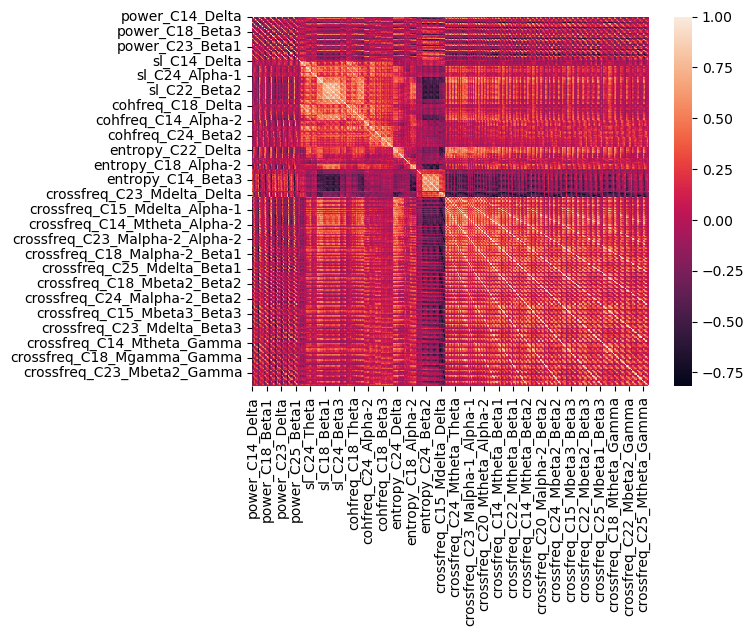

In [104]:
sns.heatmap(data.corr())
plt.savefig(path_plot+'/'+'correlation'+'_'+space+'.png')

### Árboles de decisión (Grid Search)

In [105]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 30)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini',  'entropy', 'log_loss']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion
               }

In [106]:
forestclf_grid = RandomForestClassifier()

rf_random = RandomizedSearchCV(
                              estimator=forestclf_grid,
                              param_distributions=random_grid,
                              n_iter=100,
                              cv=10,
                              verbose=2,
                              random_state=10,
                              n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 165, 231, 296,
                                                         362, 427, 493, 558,
                                                         624, 689, 755, 820,
                                                         886, 951, 1017, 1082,
                                                         1148, 1213, 1279, 1344,
                                                         1410, 1475, 1541, 1606,
                                                         1672, 1737, 1803, 1868,
                                                         1934, 2000]},
                   random_state=10, verbose=2)

In [107]:
best_selected = rf_random.best_estimator_

In [108]:
GS_fitted = best_selected.fit(X_train, y_train)
modelos['GridSerach'] = GS_fitted

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [109]:
predicted = GS_fitted.predict(X_test)

In [110]:
print(
    f"Classification report for classifier {GS_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=60,
                       max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=689):
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79        20
         1.0       0.57      0.40      0.47        10

    accuracy                           0.70        30
   macro avg       0.66      0.62      0.63        30
weighted avg       0.68      0.70      0.68        30




In [111]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics'+'_'+space+'.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


In [112]:
scores = cross_val_score(
                        estimator=GS_fitted,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )

In [113]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.66666667 0.66666667 0.66666667 0.83333333 0.58333333 0.58333333
 0.58333333 0.63636364 0.72727273 0.81818182]


In [114]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))

acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.677 +/- 0.087


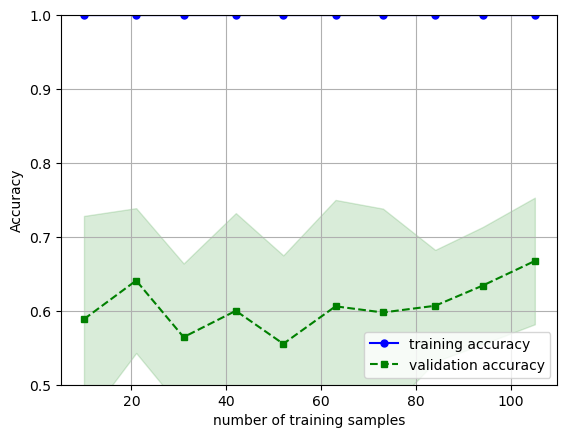

In [115]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=GS_fitted,
                  X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_GridSearch'+'_'+space+'.png')
plt.show()

### Árboles de decisión (Boruta)

In [116]:
feat_selector = BorutaPy(
                        verbose=2,
                        estimator=best_selected,
                        max_iter=100,
                        random_state=10
                        )

In [117]:
feat_selector.fit(X_train, y_train)

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	547
Rejected: 	0


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	17 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	18 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	19 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	20 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	21 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	22 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	23 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	24 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	25 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	26 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	27 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	28 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	544


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Iteration: 	29 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	544


BorutaPy finished running.

Iteration: 	30 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	544


BorutaPy(estimator=RandomForestClassifier(bootstrap=False, criterion='entropy',
                                          max_depth=60, max_features='auto',
                                          min_samples_leaf=2,
                                          min_samples_split=5,
                                          n_estimators=1000,
                                          random_state=RandomState(MT19937) at 0x1F689B9D340),
         random_state=RandomState(MT19937) at 0x1F689B9D340, verbose=2)

In [118]:
selected_features = []
print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", data.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
        selected_features.append(data.columns[i])


------Support and Ranking for each feature------
Passes the test:  power_C18_Gamma  - Ranking:  1
Passes the test:  power_C20_Gamma  - Ranking:  1
Passes the test:  sl_C18_Theta  - Ranking:  1


In [119]:
X_transform = feat_selector.transform(X_train)

In [120]:
boruta_fitted = best_selected.fit(X_transform, y_train)
modelos['Boruta'] = boruta_fitted

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [121]:
selected_features = [data.columns.get_loc(c) for c in selected_features if c in data]
selected_features

[23, 31, 76]

In [122]:
predicted = boruta_fitted.predict(X_test[:,selected_features])

In [123]:
print(
    f"Classification report for classifier {boruta_fitted}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=60,
                       max_features='auto', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=1000,
                       random_state=RandomState(MT19937) at 0x1F689B9D340):
              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        20
         1.0       0.80      0.80      0.80        10

    accuracy                           0.87        30
   macro avg       0.85      0.85      0.85        30
weighted avg       0.87      0.87      0.87        30




In [124]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_boruta'+'_'+space+'.png')

C:\Program Files\Google\Chrome\Application\chrome.exe


In [125]:
scores = cross_val_score(estimator=boruta_fitted,
                        X=X_transform,
                        y=y_train,
                        cv=10,
                        n_jobs=-1)

In [126]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.75       0.91666667 0.83333333 0.91666667 0.66666667 0.83333333
 0.58333333 0.81818182 0.81818182 0.90909091]


In [127]:
print('\nCV accuracy: %.3f +/- %.3f' %
    (np.mean(scores), np.std(scores)))


acc_per_feature.append(np.mean(scores))
std_per_feature.append(np.std(scores))


CV accuracy: 0.805 +/- 0.104


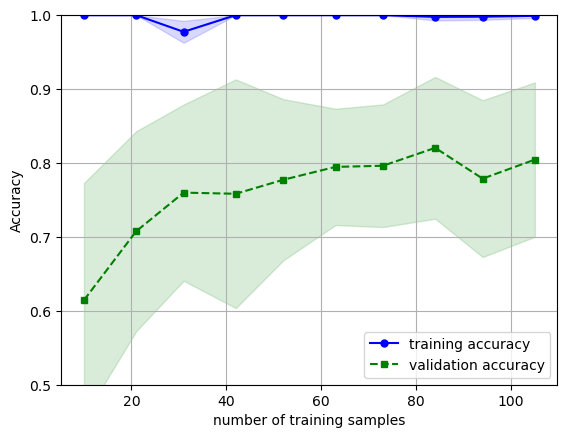

In [128]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=boruta_fitted,
                  X=X_transform,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_Boruta'+'_'+space+'.png')
plt.show()

### Selección de caracteristicas con árboles de decisión

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


 1) power_C20_Gamma                0.033331
 2) power_C18_Gamma                0.017968
 3) power_C14_Gamma                0.014235
 4) sl_C18_Theta                   0.013002
 5) power_C24_Gamma                0.012033
 6) sl_C18_Delta                   0.011782
 7) power_C25_Gamma                0.011564
 8) cohfreq_C18_Beta1              0.010717
 9) sl_C15_Beta3                   0.010377
10) cohfreq_C18_Beta2              0.010048
11) cohfreq_C15_Theta              0.010035
12) cohfreq_C25_Beta1              0.009624
13) cohfreq_C15_Delta              0.009207
14) sl_C25_Alpha-1                 0.008489
15) cohfreq_C23_Beta3              0.008412
16) crossfreq_C20_Mgamma_Gamma     0.008397
17) sl_C15_Alpha-1                 0.008121
18) entropy_C15_Beta2              0.007966
19) power_C23_Gamma                0.007700
20) sl_C15_Delta                   0.007064
21) cohfreq_C25_Theta              0.007062
22) cohfreq_C23_Beta1              0.006567
23) crossfreq_C14_Mbeta3_Beta3  

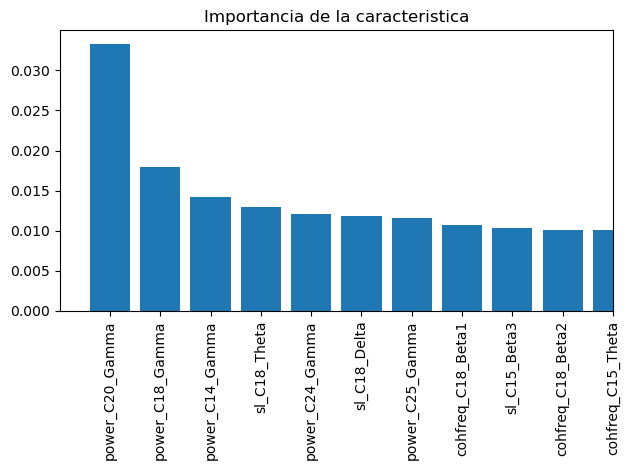

In [129]:
nombres_columnas = data.columns[:-1]
best_selected.fit(X_train, y_train)
features_scores = best_selected.feature_importances_
features_scores
index = np.argsort(features_scores)[::-1]
sorted_names = []

for f in range(X_train.shape[1]):

    sorted_names.append(nombres_columnas[index[f]])
    print("%2d) %-*s %f" % (f + 1, 30,
                        nombres_columnas[index[f]],
                        features_scores[index[f]]))
    
plt.title('Importancia de la caracteristica')

plt.bar(range(X_train.shape[1]),
    features_scores[index],
    align='center')

plt.xticks(range(X_train.shape[1]),
    nombres_columnas[index],
    rotation=90)

plt.xlim([-1, 10])

plt.tight_layout()

plt.show()

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

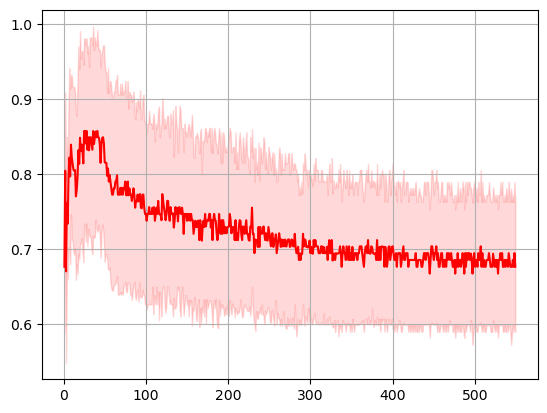

In [130]:
for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    feature_model = best_selected.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=feature_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    modelos['number_features_' + str(index)] = feature_model
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))


#plt.plot(
#        range(1, len(sorted_names)),
#        acc_per_feature,
#        color='red'
#        ) 
#
#plt.fill_between(
#                range(1, len(sorted_names)),
#                np.array(acc_per_feature) + np.array(std_per_feature),
#                np.array(acc_per_feature) - np.array(std_per_feature),
#                alpha=0.15,
#                color='red'
#                )

plt.plot(
        range(1, len(acc_per_feature)+1),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(1, len(acc_per_feature)+1),
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot'+'_'+space+'.png')
plt.show()


In [131]:
pos_model = np.argsort(acc_per_feature)[-1]
best_model = list(modelos.keys())[pos_model]
best_model

'number_features_26'

In [132]:
joblib.dump(modelos[best_model], path_plot+'/'+'modelo_entrenado'+'_'+space+'.pkl') # Guardo el modelo.

['C:\\Users\\veroh\\OneDrive - Universidad de Antioquia\\Articulo análisis longitudinal\\Resultados_Armonizacion_BD\\Graficos_ML/neuroHarmonize_G1_ic/modelo_entrenado_ic.pkl']

In [133]:
# Guardar mejore carateristicas
best_features=sorted_names[:pos_model]
mi_path = path_plot+'/'+"best_features'+'_'+space+'.txt"
f = open(mi_path, 'w')

for i in best_features:
    f.write(i+'\n')
f.close()

In [134]:
new_data = pd.DataFrame()
for i in range(0,len(data.columns)):
    for j in range(0,len(best_features)):
        if data.columns[i] == best_features[j]:
            new_data[best_features[j]] = data[best_features[j]]


In [135]:
new_name = 'Data_complete_randomforest'+space+'_'+name
new_data.reset_index(drop=True).to_feather('{path}\Datosparaorganizardataframes\ML\{name}.feather'.format(path=path,name=new_name))
            

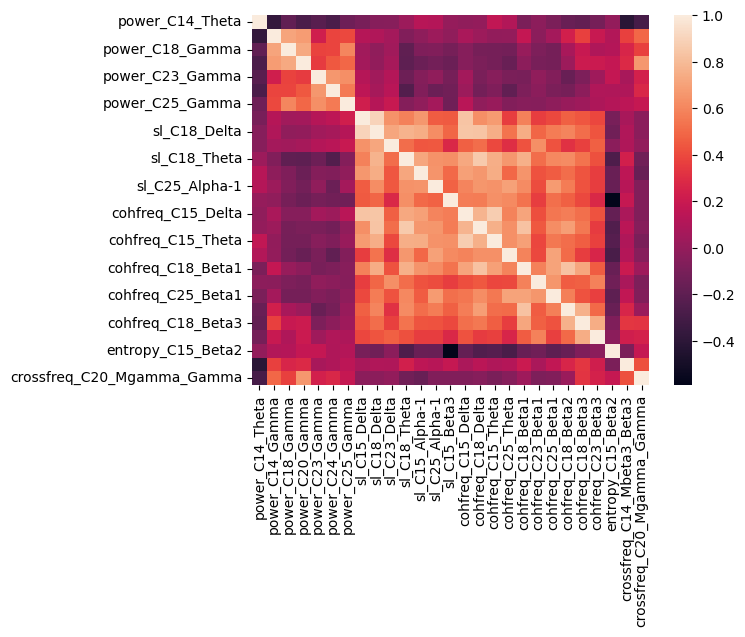

In [136]:
sns.heatmap(new_data.corr())
plt.savefig(path_plot+'/'+'correlation_randomforest'+'_'+space+'.png')

In [137]:
selected_best_features = [new_data.columns.get_loc(c) for c in best_features if c in new_data]
selected_best_features

[3,
 2,
 1,
 10,
 5,
 8,
 6,
 18,
 13,
 21,
 16,
 20,
 14,
 12,
 23,
 26,
 11,
 24,
 4,
 7,
 17,
 19,
 25,
 15,
 0,
 9,
 22]

In [138]:
best_features

['power_C20_Gamma',
 'power_C18_Gamma',
 'power_C14_Gamma',
 'sl_C18_Theta',
 'power_C24_Gamma',
 'sl_C18_Delta',
 'power_C25_Gamma',
 'cohfreq_C18_Beta1',
 'sl_C15_Beta3',
 'cohfreq_C18_Beta2',
 'cohfreq_C15_Theta',
 'cohfreq_C25_Beta1',
 'cohfreq_C15_Delta',
 'sl_C25_Alpha-1',
 'cohfreq_C23_Beta3',
 'crossfreq_C20_Mgamma_Gamma',
 'sl_C15_Alpha-1',
 'entropy_C15_Beta2',
 'power_C23_Gamma',
 'sl_C15_Delta',
 'cohfreq_C25_Theta',
 'cohfreq_C23_Beta1',
 'crossfreq_C14_Mbeta3_Beta3',
 'cohfreq_C18_Delta',
 'power_C14_Theta',
 'sl_C23_Delta',
 'cohfreq_C18_Beta3']

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for 

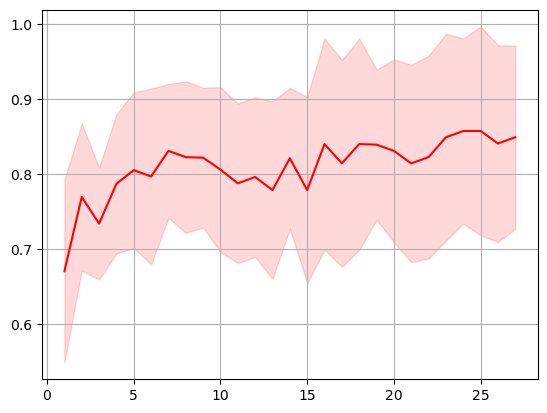

In [141]:
acc = []
std = []
m=[]
for index, feature_name in enumerate(best_features,start=1):

    input_features_best = best_features[:index]
    input_best_index = [data.columns.get_loc(c) for c 
                      in input_features_best if c in data]
    fbest_model = best_selected.fit(X_train[:, input_best_index], y_train)
    scores_best = cross_val_score(
                        estimator=fbest_model,
                        X=X_train[:, input_best_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    
  
    #m['number_features_BEST' + str(index)] = fbest_model
    acc.append(np.mean(scores_best))
    std.append(np.std(scores_best))

plt.plot(
        range(1, len(acc)+1),
        acc,
        color='red'
        ) 

plt.fill_between(
                range(1, len(acc)+1),
                np.array(acc) + np.array(std),
                np.array(acc) - np.array(std),
                alpha=0.15,
                color='red'
                )

plt.grid()
plt.savefig(path_plot+'/'+'features_plot_best'+'_'+space+'.png')
plt.show()

In [158]:
print(acc[-1])
print(std[-1])

0.8492424242424242
0.12208257528511632


In [151]:
predicted = fbest_model.predict(X_test[:,input_best_index])
classes_x=(predicted >= 0.5).astype(int)
computerprecision(y_test,classes_x)

Precision:  0.8 
 Recall:  0.8 
 F1-score: 0.8000000000000002


Confusion matrix, without normalization
[[18  2]
 [ 2  8]]


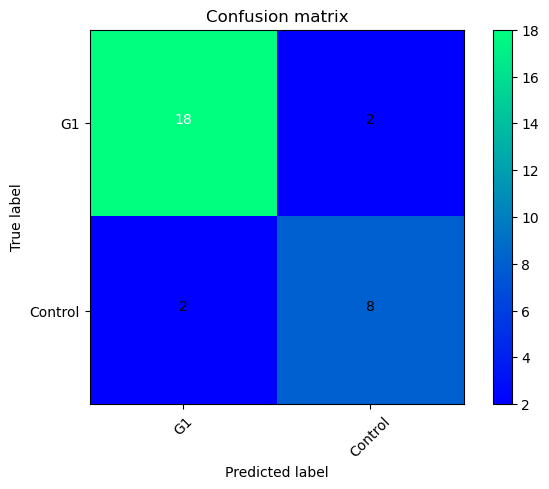

In [155]:
class_names=['G1','Control']
cm_test = confusion_matrix(y_test,classes_x)
plot_confusion_matrix(path_plot,cm_test,classes=class_names,title='Confusion matrix')

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


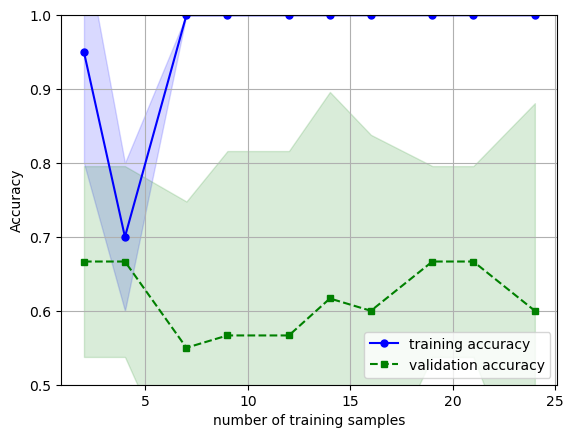

In [156]:
train_sizes, train_scores, test_scores = \
    learning_curve(
                  estimator=modelos[best_model],
                  X=X_test[selected_best_features],## Revisar
                  y=y_train[selected_best_features],
                  train_sizes=np.linspace(0.1, 1, 10),
                  cv=10,
                  n_jobs=-1
                  )
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)# test_score
test_std = np.std(test_scores, axis=1)

plt.plot(
        train_sizes,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='training accuracy'
        )

plt.fill_between(
                train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue'
                )

plt.plot(
        train_sizes,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='validation accuracy'
        )

plt.fill_between(
                train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15,
                color='green'
                )

plt.grid()
plt.xlabel('number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.0])
plt.savefig(path_plot+'/'+'validation_randomforest'+'_'+space+'.png')
plt.show()

### SVM (Grid Search)

In [ ]:
svm_param_grid = {'C': list(np.logspace(-1, 4, 6)), 
                 'gamma': list(np.logspace(-3, 2, 6)) + ['Auto'] + ['scale'],
                 'kernel': ['rbf', 'poly']} 

svc = SVC()
svc_clf = GridSearchCV(
                      svc,
                      svm_param_grid,
                      n_jobs=-1,
                      cv=10
                      )

svm_best_clf = svc_clf.fit(X_train, y_train)
best_model = svm_best_clf.best_estimator_

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 180, in fit
    self._validate_params()
  File "c:\Users\veroh\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\veroh\anaconda3\lib\site-packages\skl

In [ ]:
best_model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.001)

In [ ]:
predicted = best_model.predict(X_test)

In [ ]:
print(
    f"Classification report for classifier {best_model}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
    )

Classification report for classifier SVC(C=0.1, gamma=0.001):
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        20
         1.0       0.00      0.00      0.00        10

    accuracy                           0.67        30
   macro avg       0.33      0.50      0.40        30
weighted avg       0.44      0.67      0.53        30




c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
dataframe_metrics = metrics.classification_report(y_test, predicted, output_dict=True)
dataframe_metrics = pd.DataFrame(dataframe_metrics).T
dfi.export(dataframe_metrics, path_plot+'/'+'metrics_SVM'+'_'+space+'.png')

c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Program Files\Google\Chrome\Application\chrome.exe


### SVM (Permutation importance)

In [ ]:
# results = permutation_importance(
#                                 best_model,
#                                 X_train,
#                                 y_train,
#                                 scoring='accuracy'
#                                 )

# nombres_columnas = data.columns[:-1]
# importance = results.importances_mean
# index = np.argsort(importance)

# for v, idx in zip(importance, index):
    
#     print(f'Feature: {nombres_columnas[idx]} | Score: {v}')


### SVM con caracteristicas seleccionadas del árbol de decisión

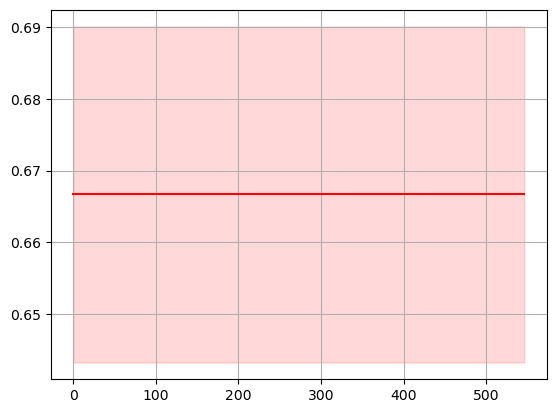

In [ ]:
acc_per_feature = []
std_per_feature = []

for index, feature_name in enumerate(sorted_names,start=1):

    input_features_names = sorted_names[:index]
    input_features_index = [data.columns.get_loc(c) for c 
                      in input_features_names if c in data]
    best_model.fit(X_train[:, input_features_index], y_train)
    scores = cross_val_score(
                        estimator=best_model,
                        X=X_train[:, input_features_index],
                        y=y_train,
                        cv=10,
                        n_jobs=-1
                        )
    acc_per_feature.append(np.mean(scores))
    std_per_feature.append(np.std(scores))

plt.plot(
        range(0, len(sorted_names)),
        acc_per_feature,
        color='red'
        ) 

plt.fill_between(
                range(0, len(sorted_names)),
                np.array(acc_per_feature) + np.array(std_per_feature),
                np.array(acc_per_feature) - np.array(std_per_feature),
                alpha=0.15,
                color='red'
                )

plt.grid()

### XGBoosting

### TPOT

In [ ]:
pipeline_optimizer = TPOTClassifier()

In [ ]:
pipeline_optimizer = TPOTClassifier(
                                    generations=5,
                                    population_size=int(X.shape[0]*0.4),
                                    cv=10,
                                    random_state=10,
                                    verbosity=3,
                                    n_jobs=-1
                                    )

In [ ]:
pipeline_optimizer.fit(X_train, y_train)

32 operators have been imported by TPOT.


Optimization Progress:   0%|          | 0/348 [00:00<?, ?pipeline/s]



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

In [ ]:
print(pipeline_optimizer.score(X_test, y_test))

0.7666666666666667


c:\Users\veroh\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py:794: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(
